In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import pickle
import random
from sklearn.model_selection import train_test_split, KFold

/Users/miaojiazheng/Downloads/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
pos = pd.read_csv("source_data/AMP0_data.csv")

In [3]:
neg = []
for dataset in ["train","test"]:
    file = open("source_data/AMPlify_non_AMP/AMPlify_non_AMP_{}_imbalanced.fa".format(dataset),"r")
    for line in file:
        if line[0] != ">":
            neg.append(line.split("\n")[0])
    file.close()

In [4]:
neglength = pd.Series(neg).apply(lambda x: len(x))
poslength = pos.drop_duplicates(["DBAASP ID"])["Sequence"].apply(lambda x: len(x))

<Axes: xlabel='Sequence', ylabel='Count'>

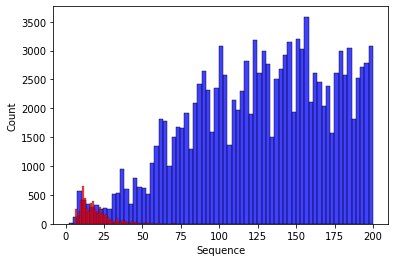

In [5]:
sns.histplot(neglength, color="blue")
sns.histplot(poslength, color="red")

In [6]:
# transform = lambda x: 0.5+(0.5/(1+np.exp((x-105)/20)))
# mic = np.array([i for i in range(1000)])
# y = transform(mic)
# sns.lineplot(mic, y)

In [7]:
pos_seq = pos["Sequence"].values
pos_label = pos['MIC (?g/mL )'].apply(lambda x: np.log2(x+1)).values
pos_state = pos["Target species"].apply(lambda x: x.replace(" ", "_"))
# neg_seq = pd.Series(neg).sample(n=len(pos_seq), replace=True, random_state=8701).values
# neg_state = pos_state.sample(n=len(pos_seq), replace=True, random_state=8701).values
# neg_label = np.zeros(len(pos_seq))
# state = np.concatenate([pos_state.values, neg_state])
# label = np.concatenate([pos_label, neg_label])
# label = label.reshape(label.shape[0], 1)
# seq = np.concatenate([pos_seq, neg_seq])

In [8]:
pos_label

array([1.27310934, 8.15159386, 7.2932424 , ..., 6.19857651, 3.45943162,
       6.65821148])

<Axes: ylabel='Count'>

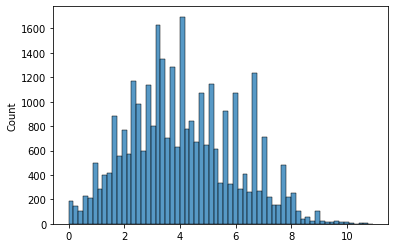

In [9]:
sns.histplot(pos_label)

In [10]:
species = pos_state.drop_duplicates().tolist()
SpeciesTV = tf.keras.layers.TextVectorization(standardize=None, split="whitespace", vocabulary=species,
                                          output_mode="multi_hot", name="SpeciesTextVectorizer")
SeqTV = tf.keras.layers.TextVectorization(max_tokens=50, standardize=None, split="character", 
                                          pad_to_max_tokens=True,
                                          output_sequence_length=max(poslength), 
                                          output_mode="int", name="SeqTextVectorizer")

In [11]:
enc_state = SpeciesTV(pos_state).numpy()
SeqTV.adapt(pos_seq)
enc_seq = SeqTV(pos_seq).numpy()

In [12]:
enc_seq.shape

(30712, 190)

In [13]:
gan_data = np.unique(pos_seq).tolist() + neg
random.seed(8701)
random.shuffle(gan_data)
gan_data = SeqTV(gan_data)

In [14]:
gan_data.shape

TensorShape([133584, 190])

In [18]:
num_group = 12
size = 133584/num_group
for i in range(num_group):
    start = int(size * i)
    end = int(size * (i+1))
    np.save(f"processed_data/gan_train_data/group_{i}", gan_data[start:end])

In [19]:
np.save("model_weights/SeqTV_vocal.npy", np.array(SeqTV.get_vocabulary()))
np.save("model_weights/SpeciesTV_vocal.npy", np.array(SpeciesTV.get_vocabulary()))

In [20]:
kf = KFold(n_splits=5, shuffle=True, random_state=8701)

In [21]:
enc_seq = np.expand_dims(enc_seq, 2).astype("float32")
enc_state = enc_state.astype("float32")
pos_label = np.expand_dims(pos_label, 1).astype("float32")

In [22]:
_, (cv_index, val_index) = list(enumerate(kf.split(pos_seq)))[0]
seq_cv = enc_seq[cv_index]
state_cv = enc_state[cv_index]
label_cv = pos_label[cv_index]
seq_test = enc_seq[val_index]
state_test = enc_state[val_index]
label_test = pos_label[val_index]

In [23]:
np.save("processed_data/test/seq_test", seq_test)
np.save("processed_data/test/state_test", state_test)
np.save("processed_data/test/label_test", label_test)
np.save("processed_data/test/seq_cv", seq_cv)
np.save("processed_data/test/state_cv", state_cv)
np.save("processed_data/test/label_cv", label_cv)
np.save("processed_data/test/seq_whole", enc_seq)
np.save("processed_data/test/state_whole", enc_state)
np.save("processed_data/test/label_whole", pos_label)

In [24]:
for i, (train_index, val_index) in enumerate(kf.split(seq_cv)):
    seq_train = seq_cv[train_index]
    state_train = state_cv[train_index]
    label_train = label_cv[train_index]
    seq_val = seq_cv[val_index]
    state_val = state_cv[val_index]
    label_val = label_cv[val_index]
    np.save("processed_data/cv/seq_train_{}".format(i), seq_train)
    np.save("processed_data/cv/state_train_{}".format(i), state_train)
    np.save("processed_data/cv/label_train_{}".format(i), label_train)
    np.save("processed_data/cv/seq_val_{}".format(i), seq_val)
    np.save("processed_data/cv/state_val_{}".format(i), state_val)
    np.save("processed_data/cv/label_val_{}".format(i), label_val)